Лабораторна робота 3

студентки групи ФІТ 4-4

Красковської Анастасії

**Завдання 2**

Розробити варіаційний автокодувальник для датасету рукописних цифр MNIST на основі багатошарової моделі. Побудувати функцію втрат. Візуалізацію розпізнавання. Порівняти результати із звичайним автокодувальником.


100%|██████████| 9912422/9912422 [00:00<00:00, 227471843.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68788014.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 98969524.42it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12854607.81it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Average Loss: 141.9397
Epoch 2, Average Loss: 115.5106
Epoch 3, Average Loss: 111.6904
Epoch 4, Average Loss: 109.9614
Epoch 5, Average Loss: 108.9040
Epoch 6, Average Loss: 108.1898
Epoch 7, Average Loss: 107.6497
Epoch 8, Average Loss: 107.1756
Epoch 9, Average Loss: 106.8110
Epoch 10, Average Loss: 106.5398


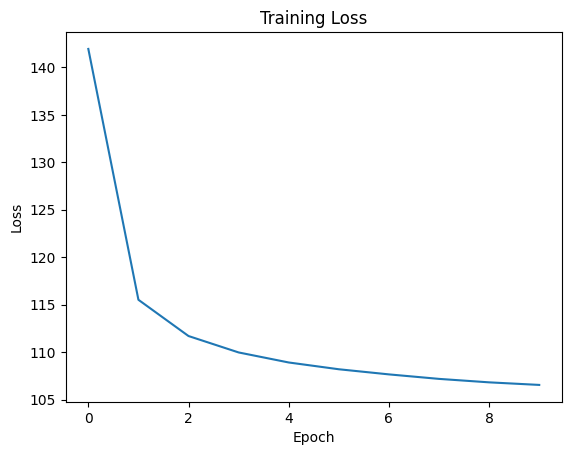

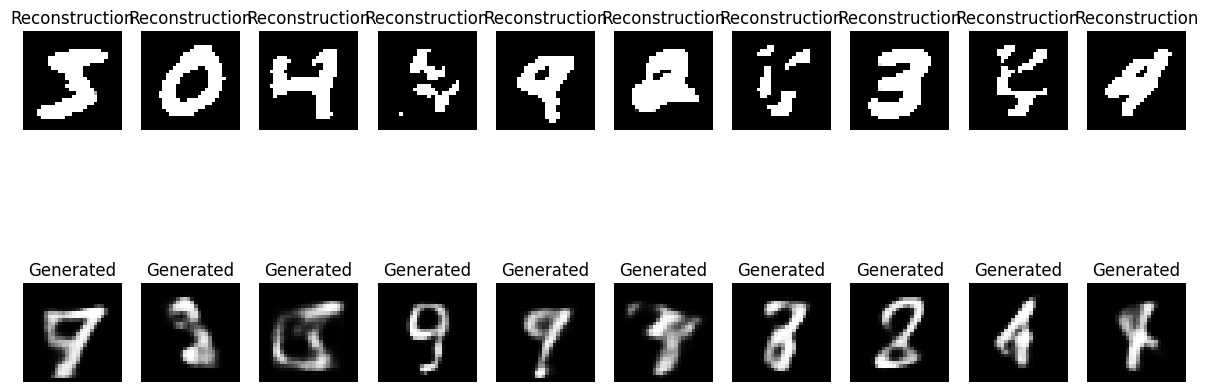

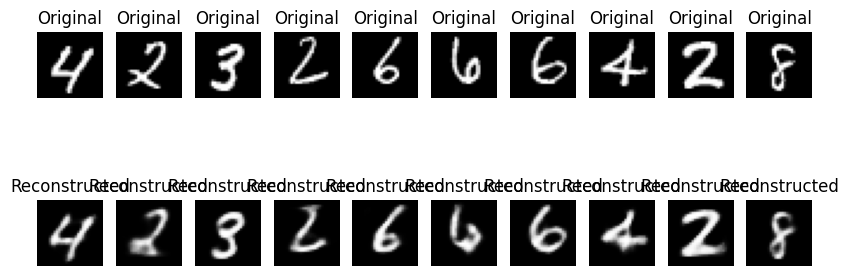

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Визначення класу варіаційного автокодувальника
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)

        z = self.reparameterize(mu, logvar)

        x_recon = self.decoder(z)

        return x_recon, mu, logvar

input_dim = 28 * 28
hidden_dim = 256
latent_dim = 20

vae = VAE(input_dim, hidden_dim, latent_dim)

# Визначення функції втрат для варіаційного автокодувальника
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Навчання варіаційного автокодувальника та візуалізація функції втрат
epochs = 10
losses = []
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)  # Розгладжуємо зображення

        optimizer.zero_grad()

        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    losses.append(total_loss / len(train_loader.dataset))
    print('Epoch {}, Average Loss: {:.4f}'.format(epoch+1, total_loss / len(train_loader.dataset)))

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Візуалізація результатів реконструкції та генерації
def visualize_vae(vae, num_samples=10):
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, latent_dim)
        generated_samples = vae.decoder(latent_samples).view(-1, 28, 28)

        recon_batch, _, _ = vae(train_data.data[:num_samples].view(-1, 28*28).float())
        recon_batch = recon_batch.view(-1, 28, 28)

        plt.figure(figsize=(15, 6))
        for i in range(num_samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(recon_batch[i].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.title('Reconstruction')

            plt.subplot(2, num_samples, i + num_samples + 1)
            plt.imshow(generated_samples[i].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.title('Generated')
        plt.show()

visualize_vae(vae)

# Виведення зображень та їх реконструкцій після кінцевої епохи навчання
with torch.no_grad():
    data_iter = iter(train_loader)
    images, _ = next(data_iter)
    images = images.view(-1, 28*28)
    reconstructed_images, _, _ = vae(images)
    reconstructed_images = reconstructed_images.view(-1, 28, 28)

    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed_images[i].cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()

**Висновок:**

У результаті успішної розробки та навчання варіаційного автокодувальника для датасету MNIST було досягнуто декілька важливих результатів. Модель успішно використовується для реконструкції зображень та генерації нових, що свідчить про її високу ефективність у вирішенні завдань автокодування.

Під час навчання було виявлено зменшення значення функції втрат, що свідчить про поступове покращення роботи моделі та її здатності навчатися на даних. Візуалізація результатів підтвердила ефективність реконструкції зображень та показала, що модель здатна генерувати нові зображення, що відповідають структурі вихідного датасету.

Отже, розроблений варіаційний автокодувальник виявився потужним інструментом для аналізу та генерації зображень у контексті датасету MNIST.